# Experimenting with EDA and Modeling 

To start off, I'm going to focus all efforts on just NY. Once everything is up and running, I'll scale up to all 50 states.

In [706]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pymongo
from pprint import pprint
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

import helper_functions
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.stattools import adfuller


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### First off, connect to MongoDB

In [4]:
client = pymongo.MongoClient('mongodb://localhost/')
db = client.admin

# Issue the serverStatus command and print the results
serverStatusResult=db.command("serverStatus")
pprint(serverStatusResult)

mydb = client['energy_data']


{'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 25, 'warning': 0},
 'connections': {'active': 1,
                 'available': 3273,
                 'current': 3,
                 'totalCreated': 16},
 'electionMetrics': {'averageCatchUpOps': 0.0,
                     'catchUpTakeover': {'called': 0, 'successful': 0},
                     'electionTimeout': {'called': 0, 'successful': 0},
                     'freezeTimeout': {'called': 0, 'successful': 0},
                     'numCatchUps': 0,
                     'numCatchUpsAlreadyCaughtUp': 0,
                     'numCatchUpsFailedWithError': 0,
                     'numCatchUpsFailedWithNewTerm': 0,
                     'numCatchUpsFailedWithReplSetAbortPrimaryCatchUpCmd': 0,
                     'numCatchUpsSkipped': 0,
                     'numCatchUpsSucceeded': 0,
                     'numCatchUpsTimedOut': 0,
                     'numStepDownsCausedByHigherTerm': 0,
                     'priorityTakeover': {'c

In [5]:
print(client.list_database_names())

['admin', 'config', 'energy_data', 'local']


In [6]:
energy_collection = mydb['energy_data']

## Get NY Data, group the data by sector, including total (renewable vs. nonrenewable)

In [473]:
ny = [x for x in energy_collection.find({'state':'New York'})]

In [474]:
# Generate list of the possible sectors to iterate through
sectors = [series.get('sector') for series in ny]
sectors = list(set(sectors))
sectors.remove(None)
sectors.sort()

### Make combined Dataframes for each NY sector

In [488]:
# Create a dictionary containing all of NY's dataframes
dataframes = {sector: helper_functions.get_energy_pop_df(ny,sector) for sector in sectors}

# Create a dataframe with just the temperature data
temp_df = helper_functions.get_weather_df(ny)

# Concatenate all these bad boys
for sector in dataframes:
    dataframes[sector] = pd.concat([dataframes[sector], temp_df],axis=1)

# Visualize NY Renewable vs. Nonrenewable Energy Consumption Across Different Sectors

In [405]:
for sector in sectors:
    helper_functions.plot_descriptive_fig(dataframes[sector], 
                                          ['Renewable Sources', 'Nonrenewable Sources'], 
                                          'NY',
                                          sector)

# Visualize NY Nonrenewable Energy Consumption Across Decades - All Sectors

In [563]:
total_df = dataframes['Total All Sectors']

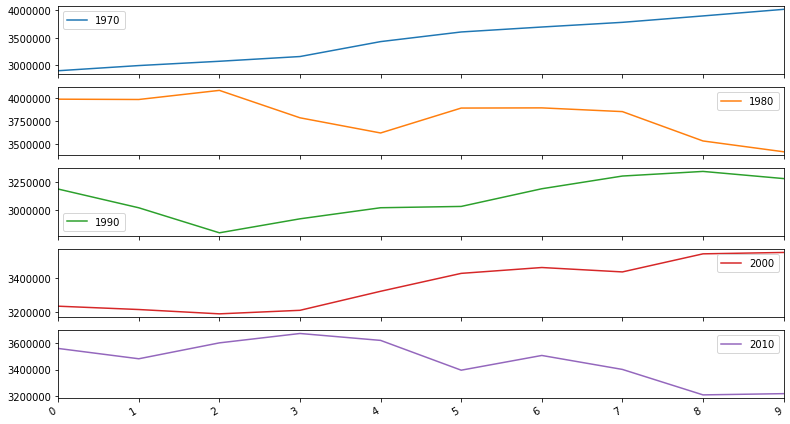

In [469]:
# Use pandas grouper to group values using annual frequency
nr_decade_groups = total_df['Nonrenewable Sources'].groupby(pd.Grouper(freq ='10Y'))

# Create a new DataFrame and store yearly values in columns 
nr_total_decades = pd.DataFrame()

for yr, group in nr_decade_groups:
    if yr.year > 1960 and yr.year < 2011:
        nr_total_decades[yr.year] = group.values
        

# Plot the yearly groups as subplots
nr_total_decades.plot(figsize = (13,8), subplots=True);

In [471]:
decades_melt = nr_total_decades.reset_index().melt(id_vars = 'index',
                                  value_vars = nr_total_decades.columns,
                                  var_name = 'Decade',
                                  value_name = 'Energy Consumed (Billion Btu)')

decades_melt.columns = ['Year Within Decade', 'Decade', 'Energy Consumed (Billion Btu)'] 

fig = px.line(decades_melt,
              x = 'Year Within Decade',
              y = 'Energy Consumed (Billion Btu)',
              color = 'Decade',
              title = 'New York Nonrenewable Energy Consumption - Total All Sectors')
fig

# Visualize NY Renewable Energy Consumption Across Decades - All Sectors

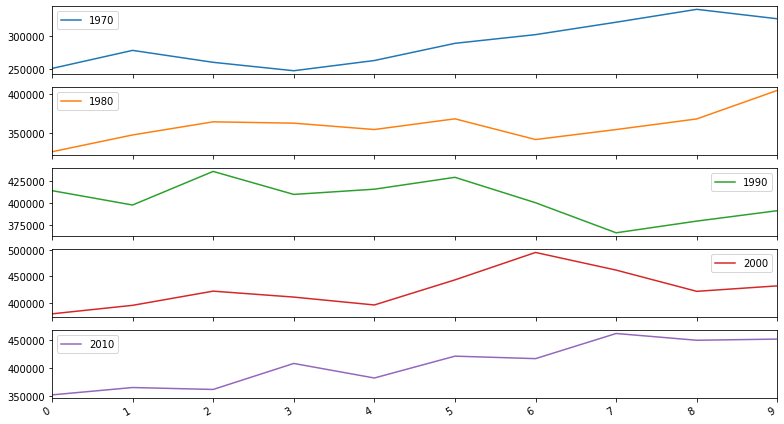

In [500]:
# Use pandas grouper to group values using annual frequency
r_decade_groups = total_df['Renewable Sources'].groupby(pd.Grouper(freq ='10Y'))

# Create a new DataFrame and store yearly values in columns 
r_total_decades = pd.DataFrame()

for yr, group in r_decade_groups:
    if yr.year > 1960 and yr.year < 2011:
        r_total_decades[yr.year] = group.values
        

# Plot the yearly groups as subplots
r_total_decades.plot(figsize = (13,8), subplots=True);

In [501]:
r_decades_melt = r_total_decades.reset_index().melt(id_vars = 'index',
                                  value_vars = r_total_decades.columns,
                                  var_name = 'Decade',
                                  value_name = 'Energy Consumed (Billion Btu)')

r_decades_melt.columns = ['Year Within Decade', 'Decade', 'Energy Consumed (Billion Btu)'] 

fig = px.line(r_decades_melt,
              x = 'Year Within Decade',
              y = 'Energy Consumed (Billion Btu)',
              color = 'Decade',
              title = 'New York Renewable Energy Consumption - Total All Sectors')
fig

# Visualize NY Temperature Data

In [497]:
temp_df_melt = temp_df.reset_index().melt(id_vars='Date',
                                value_vars= temp_df.columns,
                                var_name = 'Temperature Cutoff', 
                                value_name = 'Temperature')
temp_df_melt.columns = ['Year','Temperature Cutoff','Temperature']

In [498]:
fig = px.line(temp_df_melt, 
              x = 'Year', 
              y = 'Temperature', 
              color = 'Temperature Cutoff',
              title='New York Temperature Trends',
              height = 600,
              width = 1000)

fig.show()

# Histograms

Using to show that due to the nature of linear statistical modeling and time series, we can only select data with normally distributed variables. We thus should only focus predictions for each state on renewable vs. nonrenewable energy in **Total All Sectors**. 

Commercial Sector Histograms
Electric Power Sector Histograms
Industrial Sector Histograms
Residential Sector Histograms
Total All Sectors Histograms
Total End-Use Sectors Histograms
Transportation Sector Histograms


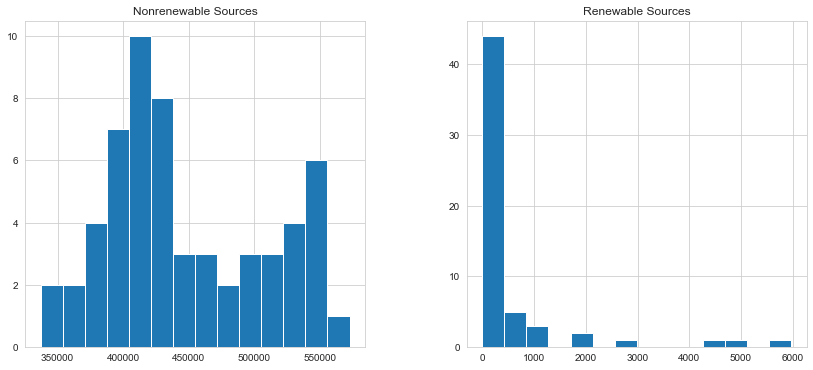

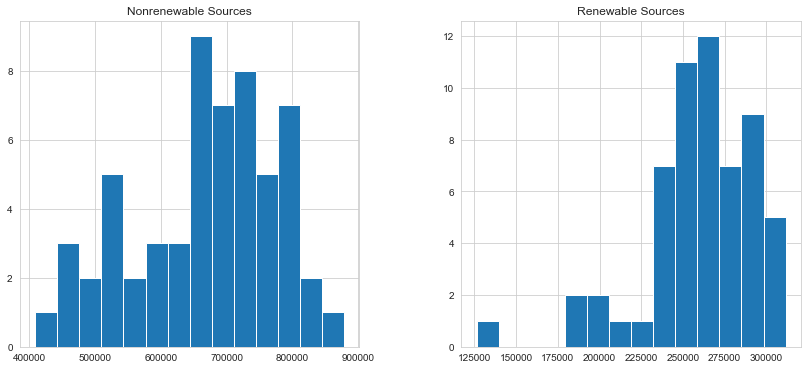

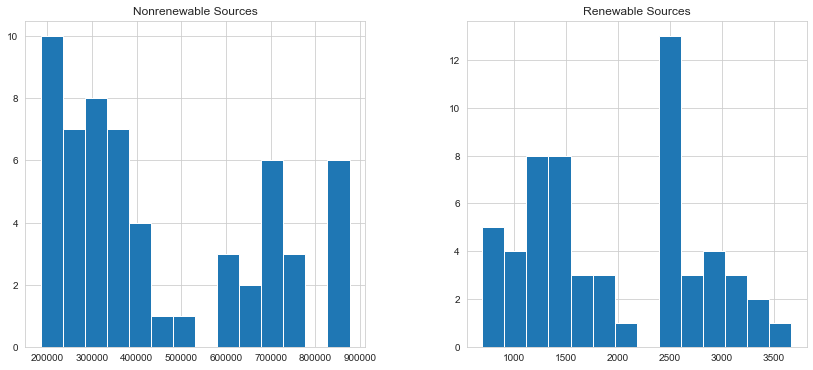

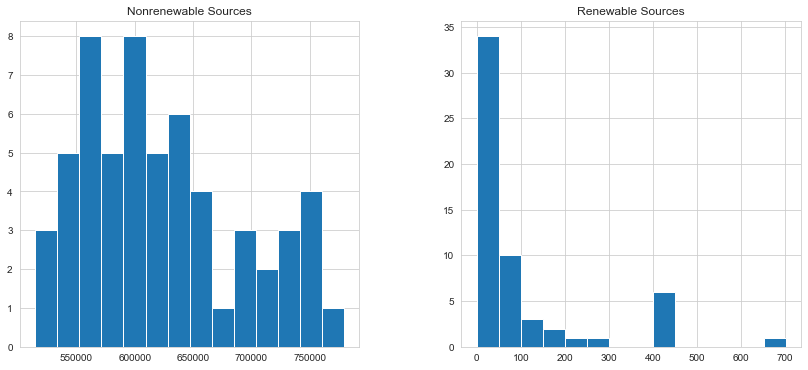

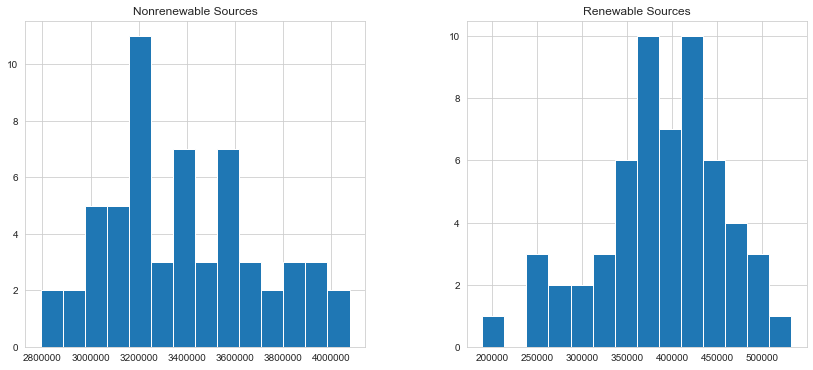

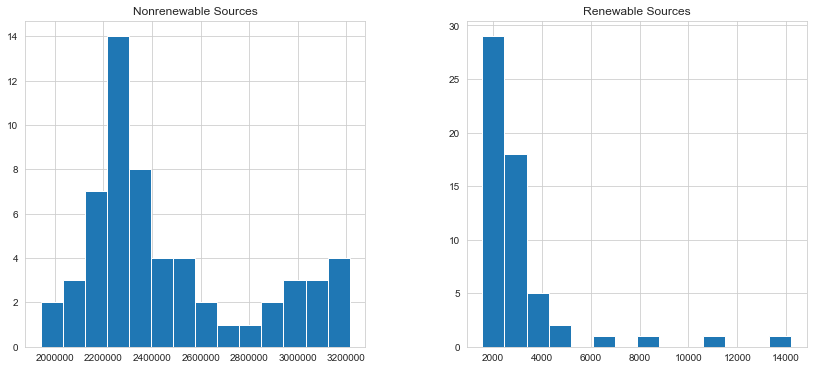

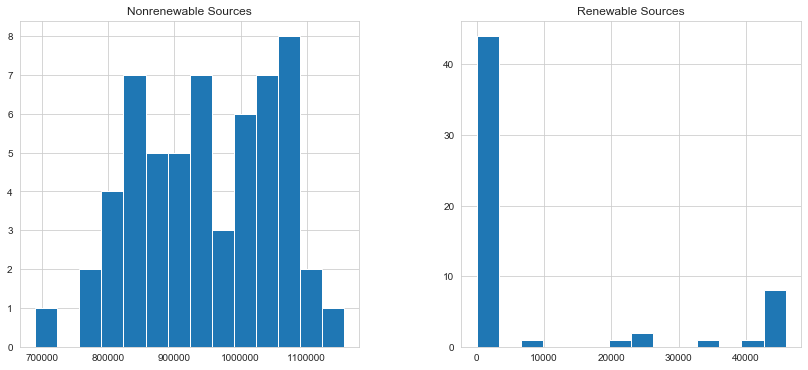

In [707]:
for sector in sectors:
    sector_df = dataframes[sector]
    print(sector, 'Histograms')
    sector_df[['Renewable Sources', 'Nonrenewable Sources']].hist(figsize = (14,6), bins= 14, );

In [544]:
fig1 = px.histogram(total_df,
             x="Nonrenewable Sources",
             marginal='rug',
             nbins=12,
             height=600,
             width=800,
             title='NY Total Nonrenewable Energy Consumption'
            )

fig2 = px.histogram(total_df,
             x="Renewable Sources",
             marginal='rug',
             nbins=12,
             height=600,
             width=800,
             title='NY Total Renewable Energy Consumption'
            )
fig1.show()
fig2.show()


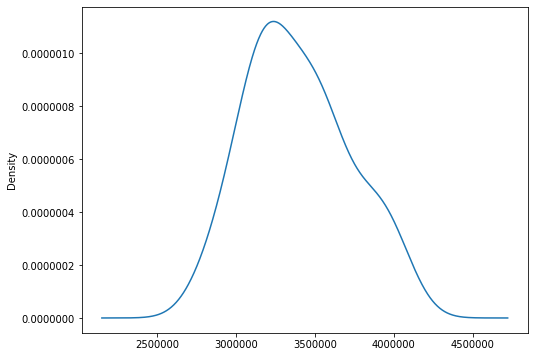

In [524]:
total_df['Nonrenewable Sources'].plot(kind='kde', figsize = (8,6));

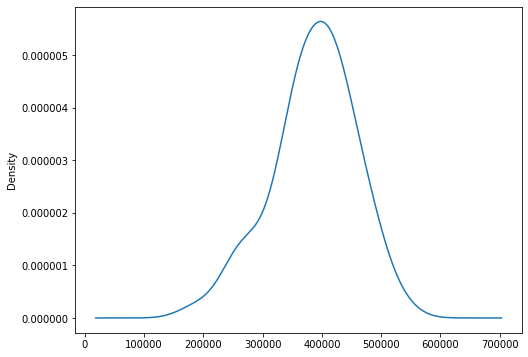

In [525]:
total_df['Renewable Sources'].plot(kind='kde', figsize = (8,6));

In [585]:
exo_columns = [total_df.columns[0]] + list(total_df.columns[17:26]) + list(total_df.columns[-4:])

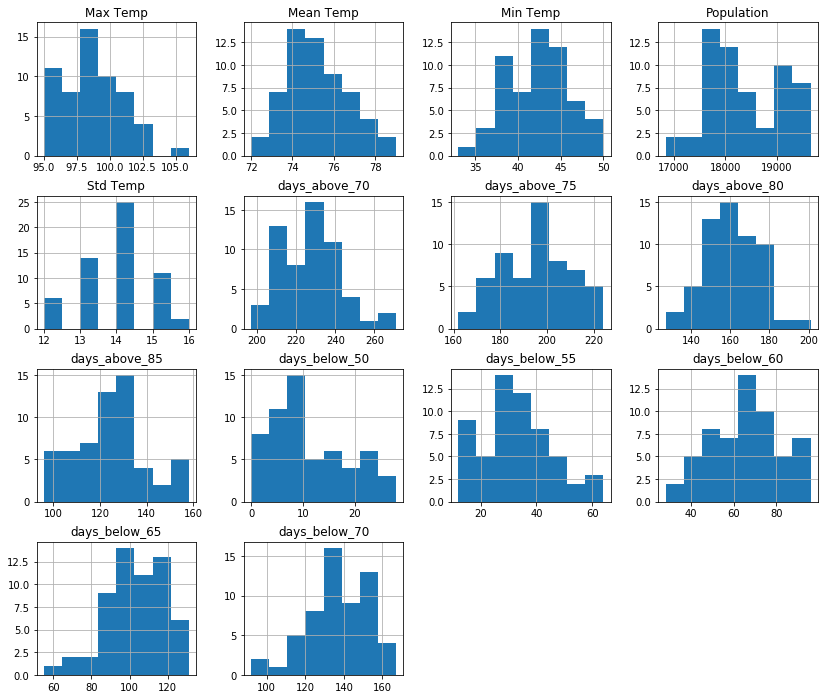

In [587]:
total_df[exo_columns].hist(figsize = (14,12), bins= 8);

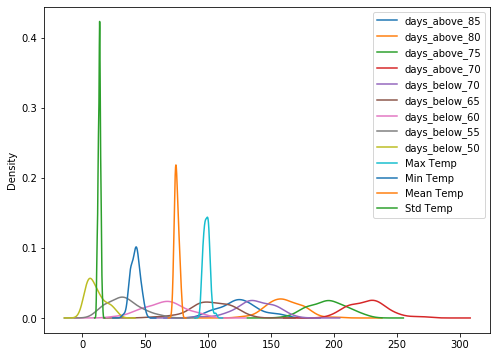

In [592]:
total_df[exo_columns[1:]].plot(kind='kde', figsize = (8,6));

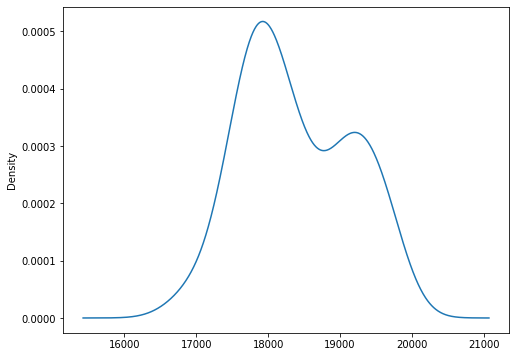

In [593]:
total_df['Population'].plot(kind='kde', figsize = (8,6));

For the most part, none of these variables are normally distributed. Population seems to be bivariate interestingly. So maybe that will not be such a great predictor in the final model.

# Summarize Findings So Far

1. New York nonrenewable energy consumption is/has much been much greater than its renewable counterpart throughout history
2. It appears that the trend over the last 20 years is that nonrenewable consumption is decreasing, while renewable consumption is increasing - many factors likely involving awareness of climate change, legislation, decreasing prices of renewable energy sources.
3. Histograms/KDE plots of energy consumption show that of all sectors, only the aggregated sector of "Total All Sectors" exhibits normally distributed energy consumption across renewable and nonrenewable energy. We'll therefore limit the scope of any forecasting to "Total All Sectors" for any state moving forward.
4. Histograms/KDE plots of exogenous variables show that pretty much all temperature designations exhibit normal, or mostly normal frequency distributions. Thus, all of these are fair game for the model.
5. Histogram/KDE plot of population reveals a bivariate distribution, which may be an issue going forward.

I dont think any logarithmic transformations will help here, but scaling will be necessary before training a model.

# Testing Stationarity

In [596]:
r_ts = total_df['Renewable Sources']
nr_ts = total_df['Nonrenewable Sources']

In [630]:
r_roll_mean = r_ts.rolling(window=6, center=False).mean()
r_roll_std = r_ts.rolling(window=6, center=False).std()

nr_roll_mean = nr_ts.rolling(window=6, center=False).mean()
nr_roll_std = nr_ts.rolling(window=6, center=False).std()

In [637]:
from plotly import subplots

In [719]:
# Create traces
fig = subplots.make_subplots(rows = 2, 
                             cols = 1,
                             vertical_spacing = 0.15,
                             subplot_titles = ['NY Renewable Energy Consumption Rolling Mean & Standard Deviation', 
                                               'NY Nonrenewable Energy Consumption Rolling Mean & Standard Deviation'])

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_ts,
                         mode='lines',
                         name='Original',
                         legendgroup = 'r',
                         line_color='#f8432d'
                         ), 
              row = 1,
              col = 1,
             )

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_roll_mean,
                         mode='lines',
                         name='Rolling Mean',
                         legendgroup = 'r',
                         line_color='#6785be'
                        ),
              row = 1,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_roll_std,
                         mode='lines', 
                         name='Rolling Std',
                         legendgroup = 'r',
                         line_color='rgb(150,150,150)'
                        ),
              row = 1, 
              col = 1)


fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_ts,
                         mode='lines',
                         name='Original',
                         showlegend=False,
                         line_color='#f8432d'),
              row = 2,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_roll_mean,
                         mode='lines',
                         name='Rolling Mean',
                         showlegend=False,
                         line_color='#6785be'),
              row = 2,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_roll_std,
                         mode='lines',
                         name='Rolling Std',
                         showlegend=False,
                         line_color='rgb(150,150,150)'),
              row = 2,
              col = 1)

fig.update_layout(height=800, 
                  width=1000, 
                  template = "plotly_white",
                  )


# Update xaxis properties
fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False, 
#                  ticks='outside',
#                  tickcolor='white',
#                  ticklen=10, 
                 row=1, col=1)

fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False, 
#                  ticks='outside',
#                  tickcolor='white',
#                  ticklen=10, 
                 row=2, col=1)


# Update yaxis properties
fig.update_yaxes(title_text='Energy Consumption (Billion Btu)', 
                 showgrid=False,
                 ticks='outside',
                 tickcolor='white',
                 ticklen=10,
                 zeroline=False, row=1, col=1)
fig.update_yaxes(title_text='Energy Consumption (Billion Btu)', 
                 showgrid=False,
                 ticks='outside',
                 tickcolor='white',
                 ticklen=10,
                 zeroline=False, 
                 row=2, col=1)


fig.show()

In [716]:
import os

if not os.path.exists("figures"):
    os.mkdir("figures")
    
fig.write_image("figures/rolling_stats.png",scale=2)

In [635]:
# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[::-1], y=nr_ts,
                    mode='lines',
                    name='Original'))
fig.add_trace(go.Scatter(x=dates[::-1], y=nr_roll_mean,
                    mode='lines',
                    name='Rolling Mean'))
fig.add_trace(go.Scatter(x=dates[::-1], y=nr_roll_std,
                    mode='lines', 
                    name='Rolling Std'))
fig.update_layout(title='NY Nonrenewable Energy Consumption Rolling Mean & Standard Deviation',
                   xaxis_title='Year',
                   yaxis_title='Energy Consumption (Billion Btu)')

fig.show()

#### The rolling means for both of the above graphs are not constant over time, indicating that our series are not stationary. Below is a Dickey-Fuller test to confirm with statistical confidence.

In [633]:
r_dftest = adfuller(r_ts)
r_dfoutput = pd.Series(r_dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in r_dftest[4].items():
    r_dfoutput['Critical Value (%s)'%key] = value
    
nr_dftest = adfuller(nr_ts)
nr_dfoutput = pd.Series(nr_dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in nr_dftest[4].items():
    nr_dfoutput['Critical Value (%s)'%key] = value

df_results = pd.concat([r_dfoutput, nr_dfoutput],axis=1)
df_results.columns = ['Renewable Sources', 'Nonrenewable Sources']

In [634]:
df_results

,Renewable Sources,Nonrenewable Sources
Test Statistic,-0.378808,-2.296522
p-value,0.913577,0.173092
#Lags Used,11.000000,1.000000
Number of Observations Used,46.000000,56.000000
Critical Value (1%),-3.581258,-3.552928
Critical Value (5%),-2.926785,-2.914731
Critical Value (10%),-2.601541,-2.595137


Using 1% critical value, we find that both test statistics are greater than the critical value. We thus reject the null hypothesis in stating that both time series exhibit non-stationary behavior.